In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn import preprocessing

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers

print(tf.__version__)


2.1.0


In [2]:
from data_processing import import_and_clean_train, label_encoding

train_X, test_X, train_y, test_y, labels_dict = import_and_clean_train('train', label_encoding)

In [3]:
# Converting the data to arrays
train_X = np.array(train_X)
train_y = np.array(train_y)
test_X = np.array(test_X)
test_y = np.array(test_y)

Preprocessing: defining the normalizer and adapting it to the train set:

In [4]:
scaler = preprocessing.StandardScaler().fit(train_X)

train_X = scaler.transform(train_X)
test_X = scaler.transform(test_X)

Function to plot the loss (mean absolute error) at each epoch:

In [35]:
# function used in the train function to plot the cost of the model
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 200000])
    plt.xlabel('Epoch')
    plt.ylabel('Error [SalePrice]')
    plt.legend()
    plt.grid(True)
    plt.show()

# funtion to plot the prediction of the test data
def plot_predictions(model):
    test_predictions = model.predict(test_X).flatten()
    a = plt.axes(aspect='equal')
    plt.scatter(test_y, test_predictions)
    plt.xlabel('True Values [SalePrice]')
    plt.ylabel('Predictions [SalePrice]')
    lims = [0, 500000]
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims, lims)
    plt.show()

# funtion to plot the error distribution of the model
def plot_errors(model):
    test_predictions = model.predict(test_X).flatten()
    error = test_predictions - test_y
    plt.hist(error, bins=25)
    plt.xlabel('Prediction Error [SalePrice]')
    _ = plt.ylabel('Count')
    plt.show()


Function to train and evaluate a model which layers are defined outside it:

In [57]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.1,
    decay_steps=10000,
    decay_rate=0.9)

In [65]:
def train_and_evaluate(model, train_x, train_y, val_x, val_y, epochs=100):

    model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(lr_schedule), metrics=['msle', 'MAPE'])

    history = model.fit(x=train_X, y=train_y, validation_data=(val_x, val_y), verbose=0, epochs=epochs)

#     plot_loss(history)

    print(f"Train loss: {history.history['loss'][-1]}, val_loss {history.history['val_loss'][-1]}")
    
    print(f"rmsle: {np.sqrt(history.history['msle'][-1])}")
    fig, axs = plt.subplots(1,2,figsize=(20,5)) 

    for i, metric in enumerate(['loss', 'MAPE']):
        axs[i].plot(history.history[metric])
        axs[i].plot(history.history['val_'+metric])
        axs[i].legend(['training', 'validation'], loc='best')

        axs[i].set_title('Model '+metric)
        axs[i].set_ylabel(metric)
        axs[i].set_xlabel('epoch')

    plt.show()

Preliminary model optimized on training loss:

Train loss: 2965.259447429978, val_loss 21358.08610249001
rmsle: 0.02665127068758011


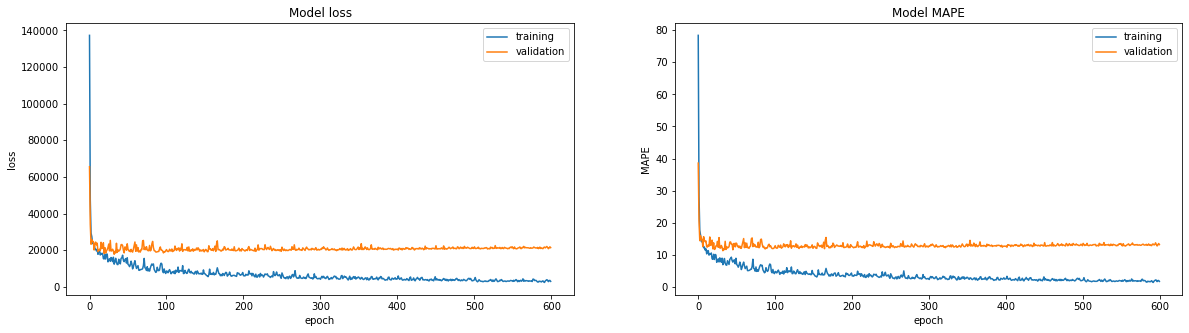

In [63]:
model = models.Sequential()
model.add(layers.Dense(79, activation='relu'))

model.add(layers.Dense(316, activation='relu'))
model.add(layers.Dense(237, activation='relu'))
model.add(layers.Dense(138, activation='relu'))

model.add(layers.Dense(1))

train_and_evaluate(model, train_X, train_y, test_X, test_y, epochs=600)

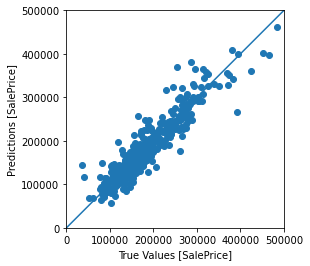

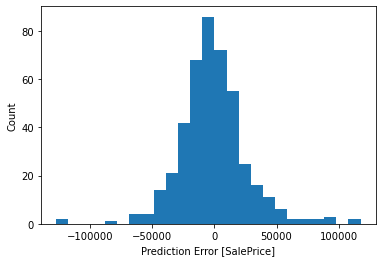

In [61]:
# Plotting the predictions of the test data based on the model
plot_predictions(model)
plot_errors(model)

Preliminary model optimized for vallidation loss:

Train loss: 14977.689781830968, val_loss 73398.33932648401
rmsle: 0.11238326877355576


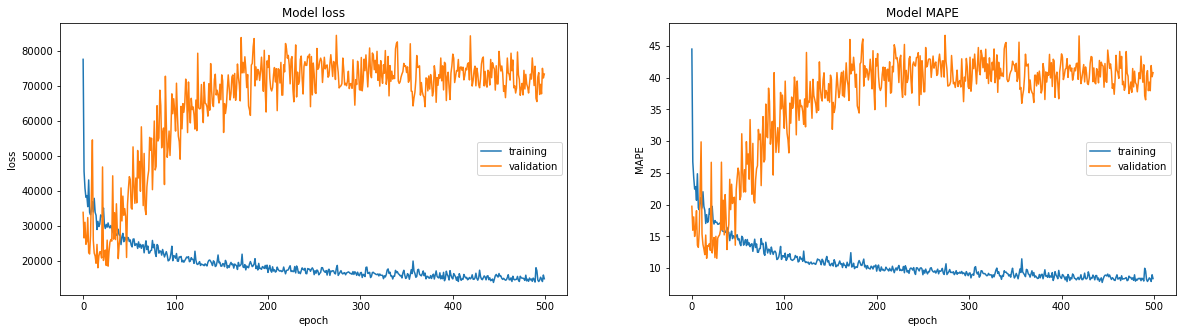

In [66]:
model = models.Sequential()
model.add(layers.Dense(79, activation='relu',
                      kernel_regularizer=regularizers.l2(0.0001)))
model.add(layers.Dropout(.5))
model.add(layers.Dense(158, activation='relu',
                      kernel_regularizer=regularizers.l2(0.0001)))
model.add(layers.Dense(79, activation='relu',
                      kernel_regularizer=regularizers.l2(0.0001)))
model.add(layers.Dense(1))

train_and_evaluate(model, train_X, train_y, test_X, test_y, epochs=500)

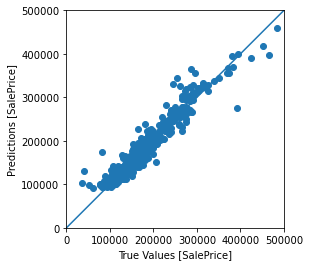

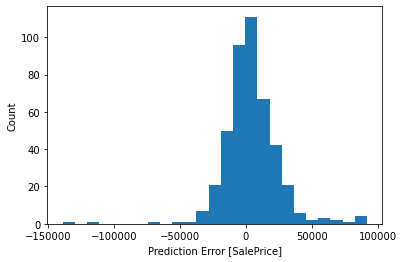

In [10]:
# Plotting the predictions of the test data based on the model
plot_predictions(model)
plot_errors(model)

Models for experimentation based on the architecture of the preliminary model:

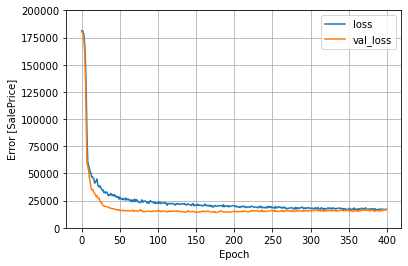

Train loss: 17224.556115077667, val_loss 16485.883401113013


In [8]:
model = models.Sequential()
model.add(layers.Dense(79, activation='relu', 
                       kernel_regularizer=regularizers.l2(0.0001)
                      ))
model.add(layers.Dropout(.5))

model.add(layers.Dense(316, activation='relu', 
                       kernel_regularizer=regularizers.l2(0.0001)
                      ))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(.5))

model.add(layers.Dense(237, activation='relu', 
                       kernel_regularizer=regularizers.l2(0.0001)
                      ))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(.2))

model.add(layers.Dense(138, activation='relu', 
                       kernel_regularizer=regularizers.l2(0.0001)
                      ))
# model.add(layers.BatchNormalization())
# model.add(layers.Dropout(.2))

model.add(layers.Dense(79, activation='relu',
                       kernel_regularizer=regularizers.l2(0.0001)
                      ))

model.add(layers.Dense(1))

train_and_evaluate(model, train_X, train_y, test_X, test_y, epochs=400)

In [38]:
import pydot
import graphviz

tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96
)

ModuleNotFoundError: No module named 'graphviz'

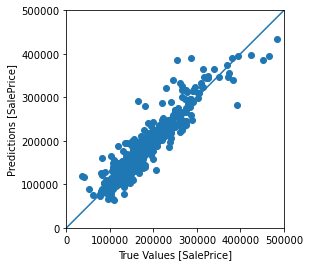

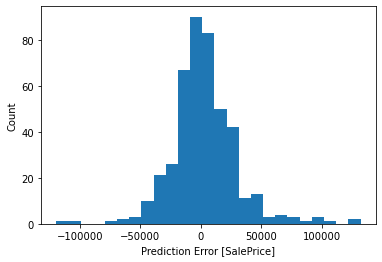

In [35]:
# Plotting the predictions of the test data based on the model
plot_predictions(model)
plot_errors(model)

In [9]:
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt

def train_and_evaluate(ktuner, model, train_x, train_y, val_x, val_y, epochs=100):
    
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

    model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(learning_rate))

    history = model.fit(x=train_X, y=train_y, validation_data=(val_x, val_y), verbose=0, epochs=epochs)

    plot_loss(history)

    print(f"Train loss: {history.history['loss'][-1]}, val_loss {history.history['val_loss'][-1]}")


ktuner = kt.HyperParameters()

model = models.Sequential()
model.add(layers.Dense(79, activation=hp.Choice("activation", ["relu", "tanh", "linear"])))
model.add(layers.Dense(138, activation=hp.Choice("activation", ["relu", "tanh", "linear"])))

model.add(layers.Dense(1))

train_and_evaluate(ktuner, model, train_X, train_y, test_X, test_y, epochs=300)

AttributeError: module 'tensorflow.keras.layers.experimental.preprocessing' has no attribute 'RandomRotation'